# Nonlinear Smoothing: Noisy Pendulum

In [ ]:
# Activate local environment, see `Project.toml`
import Pkg; Pkg.activate("."); Pkg.instantiate(); 

In this demo, we will look at a realistic dynamical system with nonlinear state transitions: tracking a noisy single pendulum.
We translate a differential equation in state-space model form to a probabilistic model.

We are tracking a pendulum with noisy observations.
You can find this example in [Bayesian Filtering & Smoothing](https://www.cambridge.org/core/books/bayesian-filtering-and-smoothing/C372FB31C5D9A100F8476C1B23721A67) by Simon Särkkä (Ex 3.7).
Its state transitions are sinusoidal in nature and it hence, qualifies as a nonlinear dynamical system.


We can describe the system with the following differential equation:

$$\begin{align*}
\frac{d}{dt} \begin{bmatrix} x_1 \\ x_2 \end{bmatrix} = \begin{bmatrix} x_2 \\ -g \sin(x_1) \end{bmatrix}
\end{align*}$$

where $x_1$ represents the angle $\alpha$ of the pendulum, $x_2$ represents the change in angle $d \alpha /dt$ and $g$ is gravitational acceleration.

We discretise the equation using a forward finite difference: $dx/dt = (x_{t+1} - x_{t})/\Delta t$. This produces the following discrete state transition:

$$\begin{align*}
\begin{bmatrix} x_{1,t+1} \\ x_{2,t+1} \end{bmatrix} = \begin{bmatrix} x_{1,t} + x_{2,t}\Delta t \\ x_{2,t} - g \sin(x_{1,t})\Delta t \end{bmatrix}
\end{align*}$$

We cannot observe the change in angle directly, only the angle itself (i.e. $x_{1}$).
We can select the first element of the state vector by taking the inner product between the vector $[1 \ 0]$ and the state vector $x_t$.

The observation is corrupted by white noise $v_t$:

$$y_t = x_{1,t} + v_t$$

where the white noise is sampled from a zero-mean Gaussian with precision $\tau^{-1}$:

$$v_t \sim \mathcal{N}(0, \tau^{-1}).$$

In [1]:
# Import libraries to julia workspace
using RxInfer, Plots, Distributions

### Generate data

In [2]:
# Dimension: time
T = 500 # interaction: total time step count == time-series: length
Δt = 0.01 # time step: duration
rT = (1:T).*Δt

# Gravitational acceleration (SI: LT⁻²)
G = 9.81

# Measurement noise precision
noise_precision = 10.

# Initial states
x0 = [1.0, 0.0]

# Initialize data array
states = zeros(2,T)
observations = zeros(T,)

# Initialize previous state variable
prev_state = x0

for t = 1:T
    # State transition
    global states[1,t] = prev_state[1] + prev_state[2]*Δt
    global states[2,t] = prev_state[2] - G*sin(prev_state[1])*Δt
    
    # Observation likelihood
    global observations[t] = states[1,t] + sqrt(inv(noise_precision))*randn(1)[1]
    
    # Update "previous state"
    global prev_state = states[:,t]
end    

Let's plot our pre-generated data to get some insights about its structure

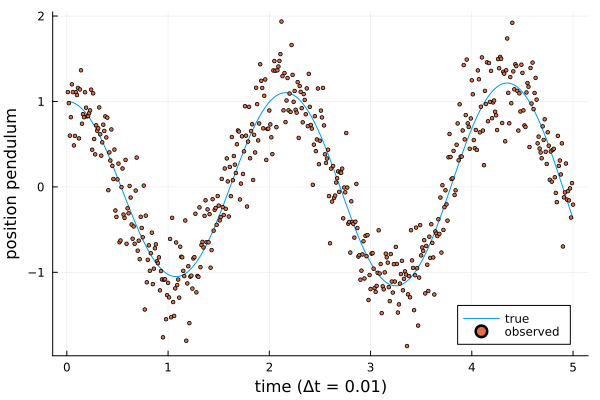

In [3]:
# Inspect data
plot(rT, states[1,:], xlabel="time (Δt = "*string(Δt)*")", ylabel="position pendulum", label="true", legend=:bottomright)
scatter!(rT, observations, ms = 2,  label="observed")

Here `g` defines the nonlinear state-transition function:

In [4]:
g(x) = [x[1] + x[2]*Δt, x[2] - G*sin(x[1])*Δt]

g (generic function with 1 method)

We use the `@model` macro to define the probabilistic model:

In [5]:
# model of the complete system dynamics
@model function noisy_pendulum(n)
    y = datavar(Float64, n)
    x = randomvar(n)
    
    τ ~ Gamma(α = 1.0, β = 1.0)
    x_0 ~ MvNormal(μ = zeros(2), Σ = diageye(2))
    
    x_prev = x_0
    for i in 1:n
        # `meta` defines the approximation method, which must be used for the nonlinear transformation
        x[i] ~ g(x_prev) where { meta = UT() }
        y[i] ~ Normal(μ = dot([1.0, 0.0], x[i]), γ=τ)
        x_prev = x[i]
    end
    
end

In [6]:
# assumed factorization of the recognition model
constraints = @constraints begin 
    q(x_0, x, τ) = q(x_0, x)q(τ)
end

Constraints:
  marginals form:
  messages form:
  factorisation:
    q(x_0, x, τ) = q(x_0, x)q(τ)
Options:
  warn = true


In [15]:
result = inference(
    model = noisy_pendulum(T), 
    data = (y = observations,),
    iterations = 5, 
    options = (limit_stack_depth = 100, ), 
    constraints = constraints, 
    initmarginals = (τ = Gamma(1.0, 1.0), ),
    free_energy = true, 
)

Inference results:
-----------------------------------------
Free Energy: Real[147.218, 140.373, 140.371, 140.371, 140.371]
-----------------------------------------
x_0 = MvNormalWeightedMeanPrecision{Float64, Vector{Float64}, Matrix{Float64}}[MvNorma...
τ   = GammaShapeRate{Float64}[GammaShapeRate{Float64}(a=251.0, b=25.947616566188096), ...
x   = Vector{MvNormalWeightedMeanPrecision{Float64, Vector{Float64}, Matrix{Float64}}}...


Lets plot the results of the inference procedure:

In [16]:
m_x_t = mean.(result.posteriors[:x][end]) 
v_x_t = cov.(result.posteriors[:x][end]);

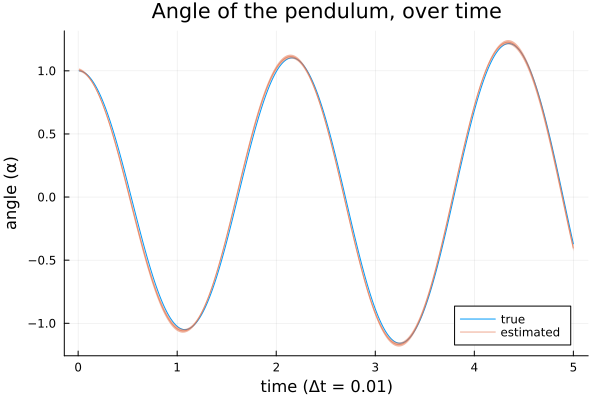

In [17]:
# Plot true states and overlay estimates
plot(rT, states[1,:], xlabel="time (Δt = "*string(Δt)*")", ylabel="angle (α)", label="true", legend=:bottomright)
plot!(rT, first.(m_x_t), ribbon=sqrt.(first.(v_x_t)), alpha=0.6, label="estimated")
title!("Angle of the pendulum, over time")

The estimated values are very close to the true values of the hidden states, but variance is not zero.

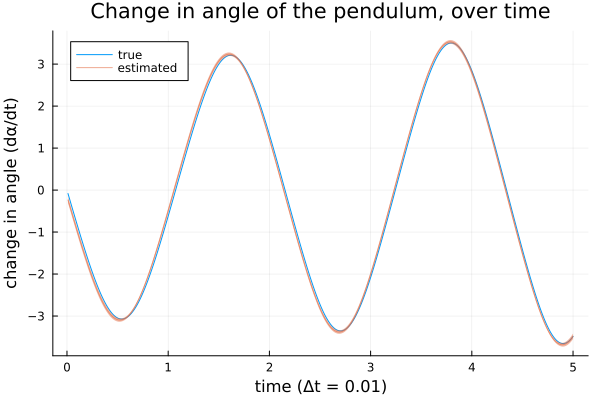

In [18]:
# Plot true states and overlay estimates
plot(rT, states[2,:], xlabel="time (Δt = "*string(Δt)*")", ylabel="change in angle (dα/dt)", label="true", legend=:topleft)
plot!(rT, last.(m_x_t), ribbon=sqrt.(last.(v_x_t)), alpha=0.6, label="estimated")
title!("Change in angle of the pendulum, over time")

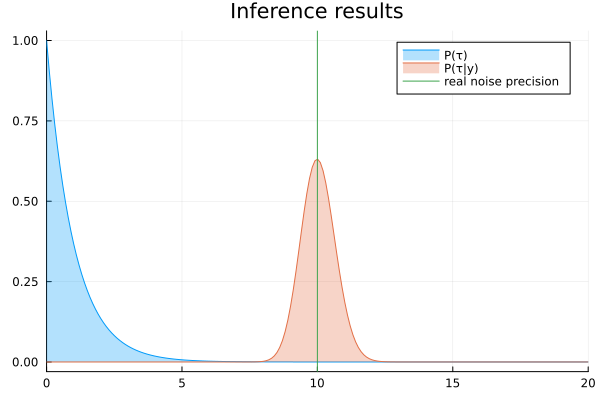

In [19]:
rTp = range(0.0, 100.0, length = 1000)

plot(rTp, (x) -> pdf(Gamma(1.0, 1.0), x), fillalpha=0.3, fillrange = 0, label="P(τ)")

let τ̂ = last(result.posteriors[:τ])
    plot!(rTp, (x) -> pdf(Gamma(shape(τ̂),scale(τ̂)), x), fillalpha=0.3, fillrange = 0, label="P(τ|y)")
end

vline!([ noise_precision ], label = "real noise precision")

plot!(xlim = (0, 20), title = "Inference results")

It is important to look at the evolution of free energy. Remember that free energy is a measure of uncertainty-weighted prediction error. 

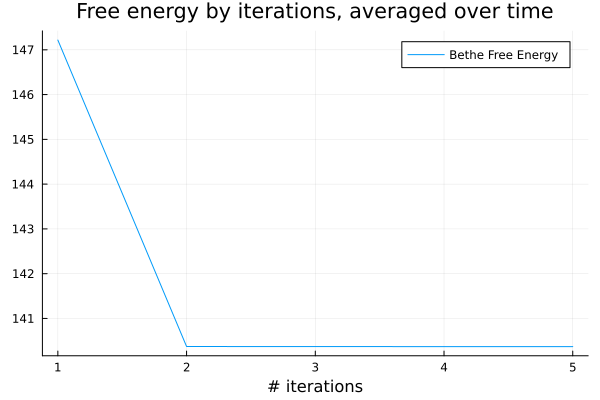

In [20]:
# Plot free energy objective
plot(result.free_energy, xlabel="# iterations", label="Bethe Free Energy")
title!("Free energy by iterations, averaged over time")